In [2]:
# Reload .py files automatically when they change, otherwise changes won't be reflected without restarting the kernel.
%load_ext autoreload
%autoreload 2

# Smart Agrifarming - Activity Recognition Pipeline

## 1. Architecture

This notebook maps to the data processing and analytics stage of the proposed pipeline. It aims to convert raw, high-frequency IoT sensor streams (MPU9250/BNO055 IMUs) into actionable insights (cow activity).

This notebook simulates the "cold path" from the architecture diagram:
1. Loads raw CSVs, simulating data ingestion from a Data Lake.
2. Transforms data using windowing, feature extraction, and caching.
3. Trains two ML models.

## 2. Data Ingestion

The raw dataset consists of CSV files representing labelled activities (e.g., "413_Walking_1219_20241021_104507.csv", where "1219" is likely the device ID, and "Walking" is the activity).

In a production environment with thousands of cows, re-parsing raw data (in this implementation, the raw CSVs) for every training run would be computationally expensive. To avoid this, our complete pipeline utilises a Data Warehouse. This notebook simulates the Data Warehouse component with a cache in the `.parquet` format. Parquet is a columnar storage format, allowing for significantly faster read times compared to row-based CSVs, particularly for large datasets. This caching mechanism means we can perform the initial transformation of the raw data into an optimised, analytics-ready form, which we then cache and re-use, drastically reducing computation.

In [3]:
from smart_agrifarming.config import ACTIVITY_COL, ID_COL, TIME_COL
from smart_agrifarming.reader import combine_datasets

df_master = combine_datasets()

Cache already exists.


## 3. Feature Engineering

Raw IMU sensor data contains acceleration, gyroscope, and magnetometer readings across multiple axes. However, machine learning models perform better when there are meaningful features that capture the patterns of different activities.

Consider these two activities:
1. Resting: Low, stable acceleration values.
2. Walking: Rythmic, periodic acceleration patterns.

Raw sensor values don't capture these distinctions, but we can extract features that can.

1. Time-Domain: Captures data distribution (e.g., mean, standard deviation, range).
2. Frequency-Domain: Patterns (e.g., walking has regular gait cycles), FFT (Fast Fourier Transform) to extract dominant frequencies.
3. Signal Magnitude Area (SMA): Represents total movement energy.
4. Zero-Crossing Rate: How often the signal changes direction.

### Edge Computation Consideration

Whilst FFT features are powerful, they are computationally expensive. The scenario's battery-constrained IoT environment means we must evaluate whether the accuracy gains justify the additional power consumption.

In [4]:
from smart_agrifarming.features import create_windowed_features

# Window configuration.
# Datapoints are every 100ms, so 20 rows is 2 seconds.
WINDOW_SIZE = 20
# Step 1 second at a time (50% overlap).
STEP_SIZE = 10

df_features = create_windowed_features(
    df_master,
    window_size=WINDOW_SIZE,
    step_size=STEP_SIZE,
)

print("Sample features:")
print(df_features.head())

# Don't include window metadata in column calculation.
print(f"\n{len(df_master)} datapoints split into {len(df_features)} windows with {len(df_features.columns) - 3} features per window.")

Sample features:
   acc_mag_mean  acc_mag_std  acc_mag_min  acc_mag_max  acc_mag_range  \
0      9.618778     0.691991     7.594770    11.023458       3.428688   
1      9.834627     0.611722     8.641084    10.983500       2.342417   
2     10.125145     0.997031     8.641084    12.374877       3.733794   
3      9.913394     1.185803     8.299503    12.374877       4.075374   
4      9.720967     1.076403     8.299503    11.668529       3.369026   

   gyro_mag_mean  gyro_mag_std        sma  MPU9250_AX_mean  MPU9250_AX_std  \
0      32.392549      7.845672  306.66028         2.809455        0.872952   
1      43.909822     15.629573  315.07381         2.832921        0.955901   
2      49.482484     16.805544  320.44659         2.689741        1.316436   
3      49.692550     15.025449  305.20457         2.605702        1.584631   
4      46.179390     17.018356  299.35293         2.740502        1.362941   

   ...  MPU9250_GZ_q25  MPU9250_GZ_q75  MPU9250_GZ_iqr  MPU9250_GZ_zcr  \
0

## 4. Test-Train Split

Before discussing the test-train split, it is important to note that activities/samples from each device were chosen by the dataset authors for their ability to train the model, not to depict realistic activity distributions for a cow over a period of time. As a consequence, each device has a unique activity distribution (see figure below) and may contain a different number of samples when compared to other devices.

### Random Split

Initially, the test-train split was achieved using scikit-learn's `test_train_split`, which randomly assigns individual datapoints into test/train sets. This caused a phenomenon called "temporal data leakage". Since consecutive IMU datapoints are similar, randomly distributing the datapoints between each set resulted in the model learning how to interpolate between nearby training points rather than generalising patterns in the data. The result was a high-accuracy (when benchmarked against the original data) model with poor real-world performance.

### Grouped Split

In order to fix the data leakage caused by randomly splitting the data, a group splitting method was introduced. The `GroupShuffleSplit`, grouped by device (using device ID), ensured all data from a device stayed in either the training or the testing set, preventing leakage. However, this introduced a new issue: class distribution. Not all devices (effectively cows) exhibited the same distribution of activities. This could be because some cows engaged in some activities more than others, but more likely, given this dataset was created and shared alongside a ML paper, the datapoints included in this dataset were specifically chosen due to their ability to best represent the patterns of each activity, and the class distribution was not an important factor when selecting the datapoints.

### Manually Grouped Split

Due to the low number of devices (10), manual analysis of the class distribution allowed a manually grouped split (see figure below). This ensures that the data leakage problem remains solved, but keeps the class distribution between testing and training sets as close as possible.

In [5]:
features_cols = [col for col in df_features.columns if col not in [TIME_COL, ACTIVITY_COL, ID_COL]]

x = df_features[features_cols]
y = df_features[ACTIVITY_COL]
groups = df_features[ID_COL]

# Split grouped by device.
test_devices = ["1217", "4821", "3120"]
train_devices = ["1219", "1319", "2016", "3321", "4119", "6019", "6319"]
train_mask = groups.isin(train_devices)
test_mask = groups.isin(test_devices)
x_train = x[train_mask]
y_train = y[train_mask]
x_test = x[test_mask]
y_test = y[test_mask]

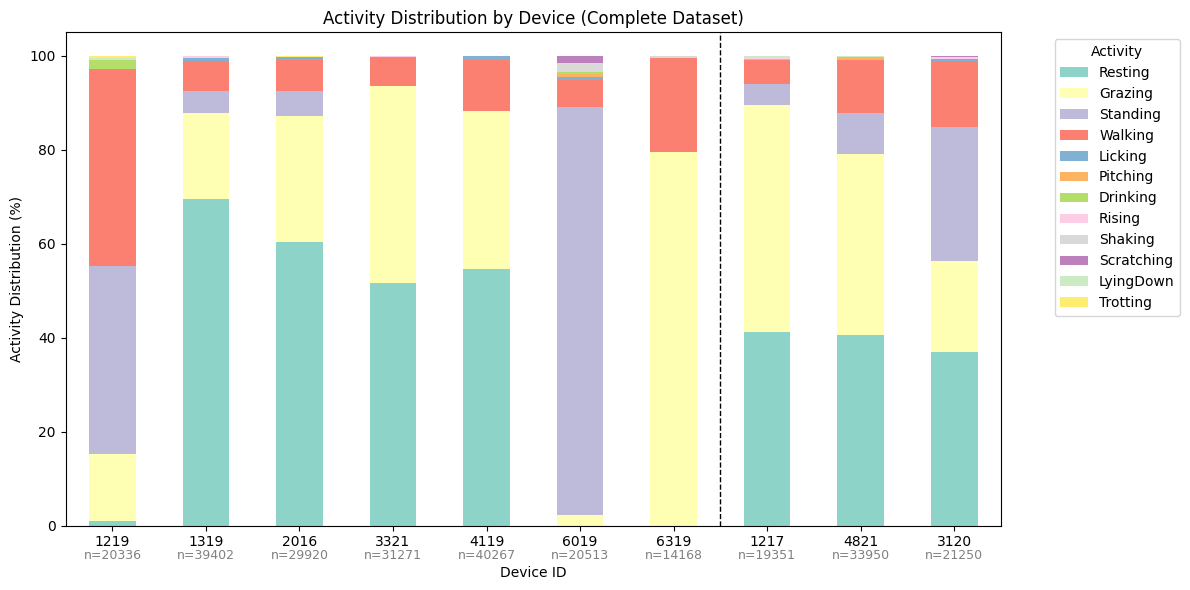

In [ ]:
import matplotlib.pyplot as plt

activity_counts = df_master.groupby([ID_COL, ACTIVITY_COL]).size().unstack(fill_value=0)
activity_counts = activity_counts.reindex(train_devices + test_devices)
activity_order = activity_counts.sum().sort_values(ascending=False).index
activity_counts = activity_counts[activity_order]
activity_percentage = activity_counts.div(activity_counts.sum(axis=1), axis=0) * 100
device_totals = activity_counts.sum(axis=1)

fig, ax = plt.subplots(figsize=(12, 6))
activity_percentage.plot(kind="bar", stacked=True, ax=ax, colormap="Set3")
ax.set_xlabel("Device ID", labelpad=12)
ax.set_ylabel("Activity Distribution (%)")
ax.set_title("Activity Distribution by Device")
ax.legend(title="Activity", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.axvline(x=6.5, color="black", linestyle="--", linewidth=1, label="Train/Test Split")
for i, (device, count) in enumerate(device_totals.items()):
    ax.text(i, -5, f"n={count}", ha="center", va="top", fontsize=9, color="grey")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 5. Feature Scaling

Machine learning algorithms that rely on distance calculations (like SVC) are sensitive to the magnitude of their inputs. Without scaling, features with larger ranges dominate a model's decisions, even if lower magnitude features are better predictors. In the data, features like acceleration magnitude (5-15m/s<sup>2</sup>) would dominate features like the acceleration's standard deviation (0.5-2m/s<sup>2</sup>) by 10x.

The `StandardScaler` normalises each feature, ensuring all features contribute equally to the model.

### Scaling Test Data

To prevent the training data leaking to the testing data, the scaler is fit using solely the training data. The resultant transformation is then applied to both datasets.

In [6]:
from sklearn.preprocessing import StandardScaler

# Scale features.
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## 6. Addressing Class Imbalance

The cow IMU dataset suffers with class imbalance. There are some activities (e.g., resting and grazing) that occur much more frequently than others (e.g., shaking and scratching). Without addressing this imbalance, the model optimises for accuracy by predicting classes that occur more frequently, whilst completely ignoring rare classes even if the underlying features are more closely aligned with them.

### SMOTE

To solve this, we can create synthetic samples for the rarer classes using SMOTE (Synthetic Minority Over-sampling Technique), which works by interpolating between existing samples.

Whilst this ensures the model trains on all classes equally, synthetic data is no substitute for real data. The reality of these rarer classes may be more varied than the existing data implies, something that interpolated data cannot replicate. This problem is particularly prominent in classes with very low sample sizes, hence classes with less than 100 samples have been completely removed.

In [7]:
from imblearn.over_sampling import SMOTE
import pandas as pd

print(f"Class distribution before balancing ({len(y_train)} total samples):")
print(y_train.value_counts())

# Remove classes with too few samples (else real to synthetic ratio will be awful).
MIN_SAMPLE_THRESHOLD = 100
class_counts = y_train.value_counts()
valid_classes = class_counts[class_counts >= MIN_SAMPLE_THRESHOLD].index
train_mask = y_train.isin(valid_classes)
test_mask = y_test.isin(valid_classes)
x_train_filtered = x_train_scaled[train_mask]
y_train_filtered = y_train[train_mask]
x_test_filtered = x_test_scaled[test_mask]
y_test_filtered = y_test[test_mask]

# Apply SMOTE.
min_samples = pd.Series(y_train_filtered).value_counts().min()
smote = SMOTE(sampling_strategy="auto", random_state=42, k_neighbors=min_samples - 1)
x_train_balanced, y_train_balanced = smote.fit_resample(x_train_filtered, y_train_filtered)

print(f"\nClass distribution after balancing ({len(y_train_balanced)} total samples):")
print(pd.Series(y_train_balanced).value_counts())

print(f"\n{len(y_train_balanced) - len(y_train)} synthetic samples created.")

Class distribution before balancing (19578 total samples):
Activity
Resting       8368
Grazing       5672
Standing      2931
Walking       2330
Licking         85
Drinking        47
Shaking         42
Scratching      33
Rising          24
Pitching        21
Trotting        15
LyingDown       10
Name: count, dtype: int64

Class distribution after balancing (33472 total samples):
Activity
Walking     8368
Standing    8368
Grazing     8368
Resting     8368
Name: count, dtype: int64

13894 synthetic samples created.


## 7. Models

### Random Forest Classifier (RFC)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train.
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rfc_model.fit(x_train_balanced, y_train_balanced)

# Evaluate.
rfc_y_pred = rfc_model.predict(x_test_filtered)
print(f"Accuracy: {accuracy_score(y_test_filtered, rfc_y_pred):.1%}")
print("\nClassification Report:")
print(classification_report(y_test_filtered, rfc_y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_filtered, rfc_y_pred))

Accuracy: 81.8%

Classification Report:
              precision    recall  f1-score   support

     Grazing       0.94      0.98      0.96      2660
     Resting       0.80      0.92      0.86      2962
    Standing       0.32      0.06      0.10       980
     Walking       0.62      0.83      0.71       780

    accuracy                           0.82      7382
   macro avg       0.67      0.70      0.66      7382
weighted avg       0.77      0.82      0.78      7382

Confusion Matrix:
[[2597    6    4   53]
 [  19 2734  118   91]
 [   4  662   59  255]
 [ 129    1    1  649]]


### Support Vector Classifier (SVC)

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train.
svc_model = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)
svc_model.fit(x_train_balanced, y_train_balanced)

# Evaluate.
svc_y_pred = svc_model.predict(x_test_filtered)
print(f"Accuracy: {accuracy_score(y_test_filtered, svc_y_pred):.1%}")
print("\nClassification Report:")
print(classification_report(y_test_filtered, svc_y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_filtered, svc_y_pred))

Accuracy: 84.2%

Classification Report:
              precision    recall  f1-score   support

     Grazing       0.96      0.96      0.96      2660
     Resting       0.82      0.95      0.88      2962
    Standing       0.66      0.13      0.21       980
     Walking       0.64      0.89      0.74       780

    accuracy                           0.84      7382
   macro avg       0.77      0.73      0.70      7382
weighted avg       0.83      0.84      0.81      7382

Confusion Matrix:
[[2565    8   24   63]
 [  18 2825   37   82]
 [   7  598  125  250]
 [  77    2    4  697]]


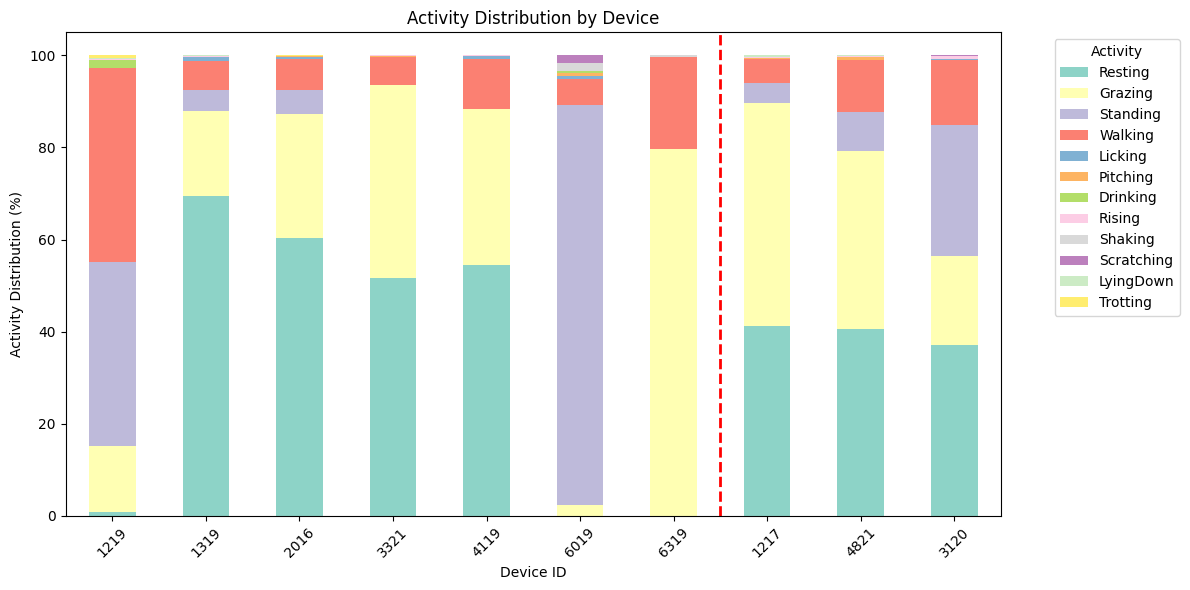